In [ ]:
from google.colab import files

print("请上传你的 Visium 压缩包 (.zip 或 .tar.gz)")
uploaded = files.upload()

请上传你的 Visium 压缩包 (.zip 或 .tar.gz)


Saving Visium_HD_Human_Lung_Cancer_binned_outputs.zip to Visium_HD_Human_Lung_Cancer_binned_outputs.zip


In [ ]:
import zipfile
with zipfile.ZipFile("Visium_HD_Human_Lung_Cancer_binned_outputs.zip", 'r') as zip_ref:
    zip_ref.extractall("Visium_HD_Human_Lung_Cancer_binned_outputs")

In [ ]:
!git clone https://github.com/prabhakarlab/Banksy_py.git
!pip install scanpy anndata pandas matplotlib pyarrow leidenalg igraph --quiet

In [ ]:
import sys
sys.path.append('/content/Banksy_py')
sys.path.append('/content/Banksy_py/banksy')
sys.path.append('/content/Banksy_py/banksy_utils')

import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

from initialize_banksy import initialize_banksy
from embed_banksy import generate_banksy_matrix
from run_banksy import run_banksy_multiparam
import plot_banksy

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
from banksy.main import generate_spatial_weights_fixed_nbrs
from banksy.embed_banksy import generate_banksy_matrix

h5_file = "/content/Visium_HD_Human_Lung_Cancer_binned_outputs/Visium_HD_Human_Lung_Cancer_binned_outputs/filtered_feature_bc_matrix.h5"
adata = sc.read_10x_h5(h5_file)

spatial_file = "/content/Visium_HD_Human_Lung_Cancer_binned_outputs/Visium_HD_Human_Lung_Cancer_binned_outputs/spatial/tissue_positions.parquet"
spatial = pd.read_parquet(spatial_file)

spatial_filtered = spatial[spatial['barcode'].isin(adata.obs_names)].copy()

spatial_filtered = spatial_filtered.set_index('barcode').loc[adata.obs_names]

adata.obs['x'] = spatial_filtered['pxl_row_in_fullres'].values
adata.obs['y'] = spatial_filtered['pxl_col_in_fullres'].values

adata = adata[spatial_filtered['in_tissue'].values == 1].copy()

x = adata.obs['x'].values
y = adata.obs['y'].values

print("X range:", x.min(), " ~ ", x.max())
print("Y range:", y.min(), " ~ ", y.max())

x_min, x_max = x.min(), x.min() + 5000
y_min, y_max = y.min(), y.min() + 5000
mask = (x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)
adata = adata[mask].copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var['highly_variable']].copy()

print("HVG gene:", adata.n_vars)
print("crooped spot:", adata.n_obs, "gene number:", adata.n_vars)


In [ ]:
from anndata import AnnData

coords = adata.obs[['x', 'y']].values
weights_graph, distance_graph, theta_graph = generate_spatial_weights_fixed_nbrs(
    coords,
    num_neighbours=5
)

banksy_dict = {
    'scaled_gaussian': {
        'weights': {0: weights_graph},
        'distances': {0: distance_graph},
        'theta': {0: theta_graph}
    }
}
lambda_list = [1]

res = generate_banksy_matrix(adata, banksy_dict, lambda_list, max_m=0)

if isinstance(res, tuple) and len(res) == 2:
    banksy_dict_out, adata_banksy = res
elif isinstance(res, AnnData):
    banksy_dict_out, adata_banksy = None, res
else:
    raise RuntimeError("Unexpected return from generate_banksy_matrix")

adata.obsm['X_banksy'] = adata_banksy.X
print("Banksy 特征 shape:", adata.obsm['X_banksy'].shape)

流式输出内容被截断，只能显示最后 5000 行内容。
normalized sum from ptr 19600 to 19605 (5 entries) 1.0
normalized sum from ptr 19605 to 19610 (5 entries) 1.0000000000000002
normalized sum from ptr 19610 to 19615 (5 entries) 1.0
normalized sum from ptr 19615 to 19620 (5 entries) 1.0
normalized sum from ptr 19620 to 19625 (5 entries) 1.0000000000000002
normalized sum from ptr 19625 to 19630 (5 entries) 1.0
normalized sum from ptr 19630 to 19635 (5 entries) 1.0
normalized sum from ptr 19635 to 19640 (5 entries) 1.0
normalized sum from ptr 19640 to 19645 (5 entries) 1.0
normalized sum from ptr 19645 to 19650 (5 entries) 1.0
normalized sum from ptr 19650 to 19655 (5 entries) 1.0
normalized sum from ptr 19655 to 19660 (5 entries) 1.0
normalized sum from ptr 19660 to 19665 (5 entries) 0.9999999999999999
normalized sum from ptr 19665 to 19670 (5 entries) 0.9999999999999999
normalized sum from ptr 19670 to 19675 (5 entries) 1.0
normalized sum from ptr 19675 to 19680 (5 entries) 1.0
normalized sum from ptr 19680 to 

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


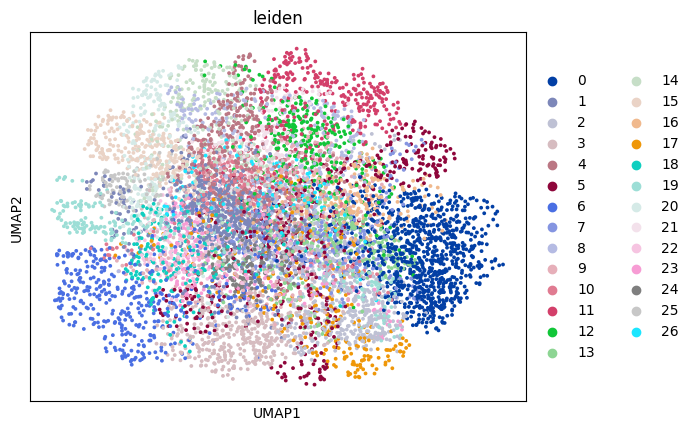

In [ ]:
sc.pp.pca(adata, n_comps=20, use_highly_variable=False)
sc.pp.neighbors(adata, use_rep='X_banksy')
sc.tl.leiden(adata, resolution=1)
sc.tl.umap(adata)

sc.pl.umap(adata, color=['leiden'], size=30)

/usr/local/lib/python3.12/dist-packages/scanpy/preprocessing/_pca/__init__.py:227: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  mask_var_param, mask_var = _handle_mask_var(


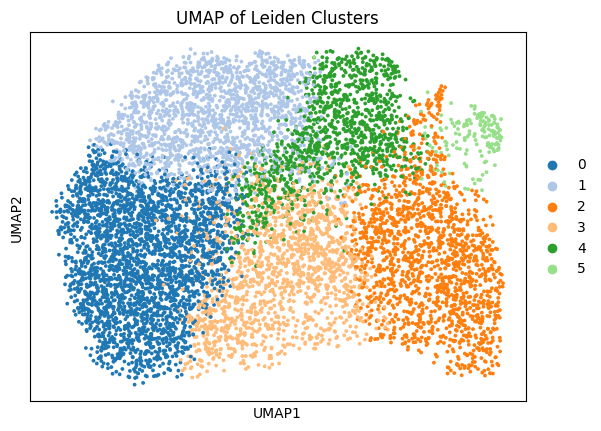

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sc.pp.pca(adata, n_comps=20, use_highly_variable=False)
sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.leiden(adata, resolution=0.5)
sc.tl.umap(adata)

unique_labels = np.sort(adata.obs['leiden'].astype(str).unique())

cmap = plt.get_cmap('tab20')
color_dict = {label: cmap(i) for i, label in enumerate(unique_labels)}

sc.pl.umap(adata, color=['leiden'], palette=color_dict, size=30, title="UMAP of Leiden Clusters")
plt.show()

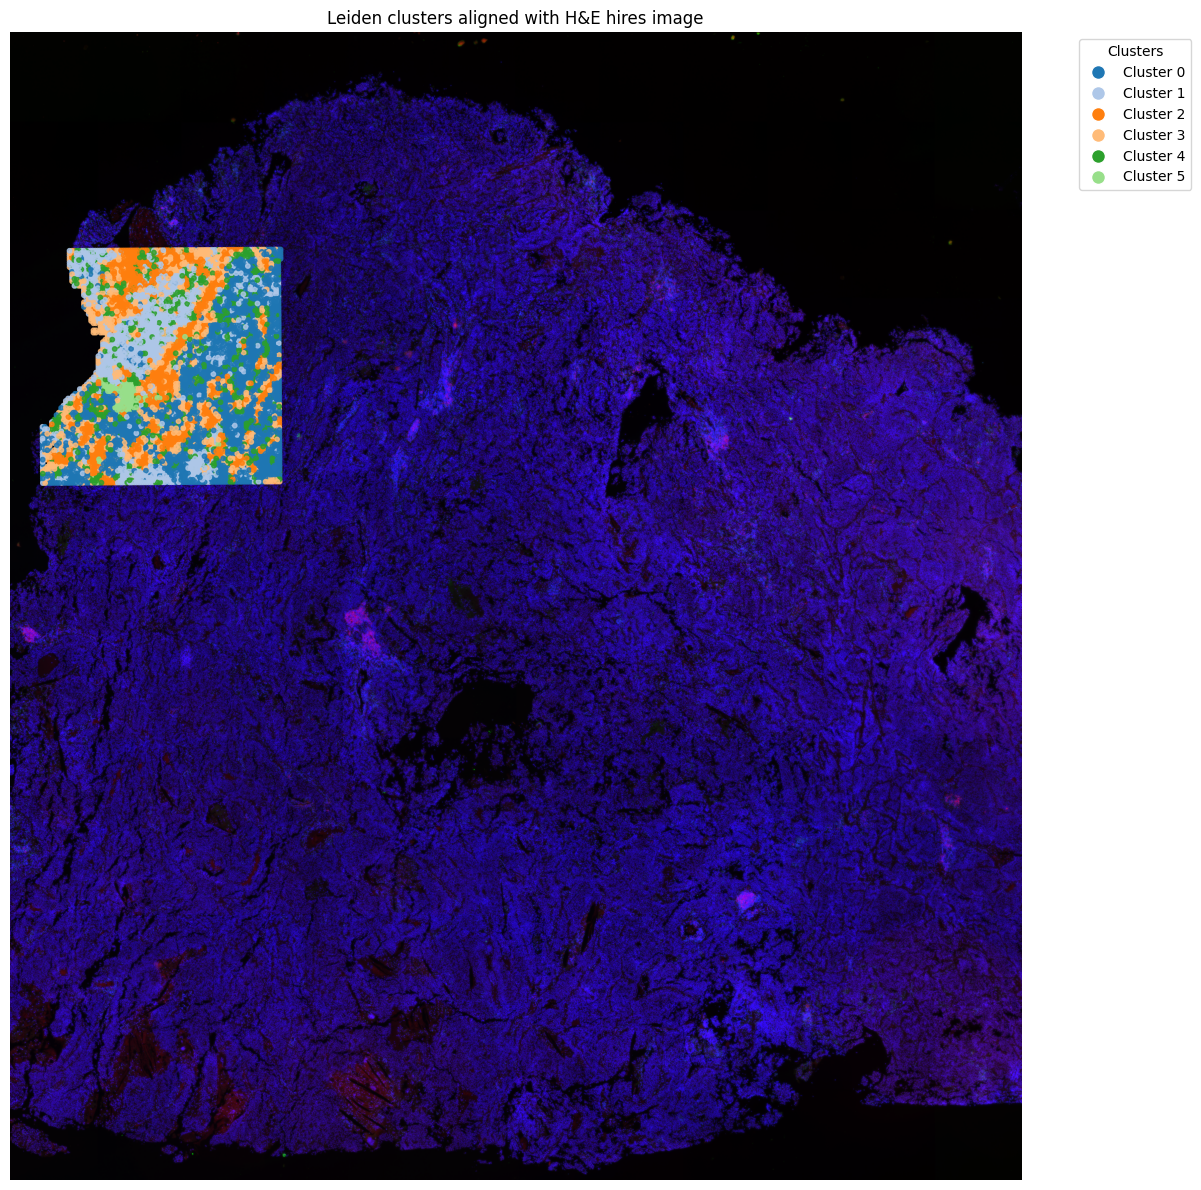

In [ ]:
import json
import cv2

scalefactors_path = "/content/Visium_HD_Human_Lung_Cancer_binned_outputs/Visium_HD_Human_Lung_Cancer_binned_outputs/spatial/scalefactors_json.json"
with open(scalefactors_path, "r") as f:
    scalefactors = json.load(f)

scale = scalefactors["tissue_hires_scalef"]

adata.obs["x_hires"] = adata.obs["x"] * scale
adata.obs["y_hires"] = adata.obs["y"] * scale
he_image_path = "/content/Visium_HD_Human_Lung_Cancer_binned_outputs/Visium_HD_Human_Lung_Cancer_binned_outputs/spatial/tissue_hires_image.png"
he_image = cv2.imread(he_image_path)
he_image = cv2.cvtColor(he_image, cv2.COLOR_BGR2RGB)

colors = []
for label in adata.obs['leiden'].astype(str):
    if pd.isna(label):
        colors.append((0, 0, 0, 0))
    else:
        colors.append(color_dict.get(label, (0, 0, 0, 1)))

plt.figure(figsize=(12, 12))
plt.imshow(he_image)
scatter = plt.scatter(
    adata.obs['y_hires'],
    adata.obs['x_hires'],
    c=colors,
    s=10,
    alpha=0.8
)

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_dict[label],
                              markersize=10, label=f'Cluster {label}') for label in unique_labels]
plt.legend(handles=legend_elements, title='Clusters', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Leiden clusters aligned with H&E hires image")
plt.axis("off")
plt.tight_layout()
plt.show()

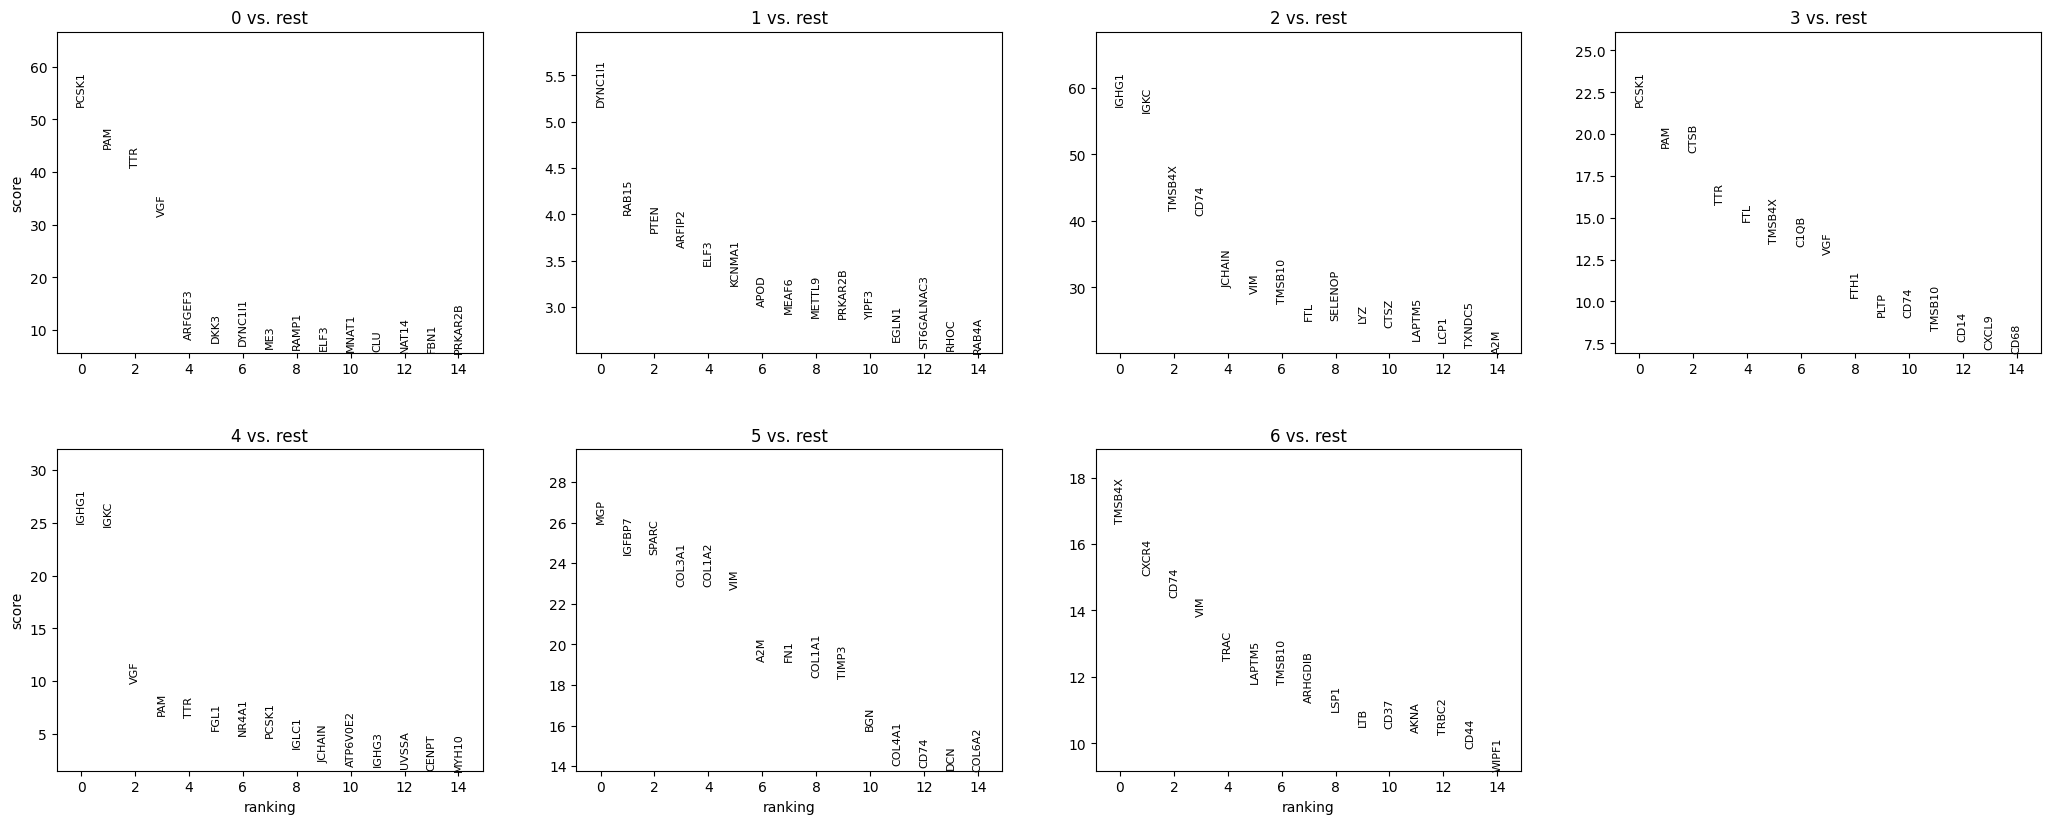

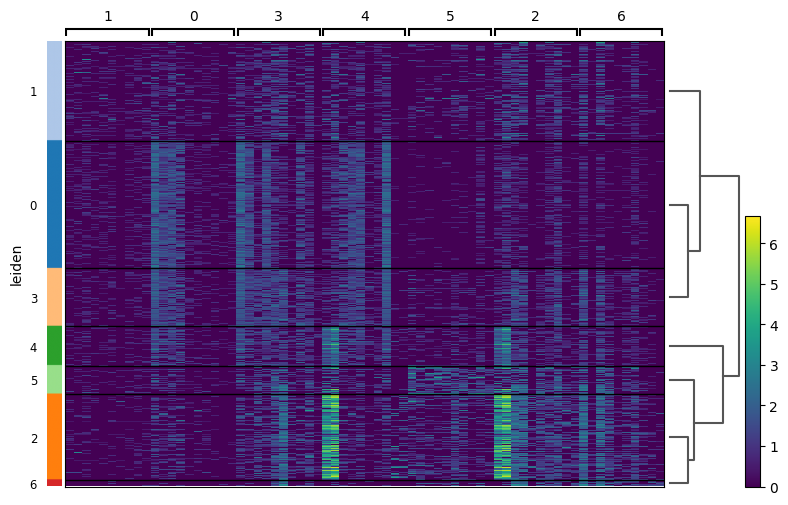

In [ ]:
adata.var_names_make_unique()

sc.tl.rank_genes_groups(
    adata,
    groupby="leiden",
    method="wilcoxon",
    key_added="rank_genes_banksy"
)


sc.pl.rank_genes_groups(
    adata,
    n_genes=15,
    key="rank_genes_banksy",
    sharey=False
)


sc.pl.rank_genes_groups_heatmap(
    adata,
    key="rank_genes_banksy",
    n_genes=10,
    groupby="leiden",
    show=True
)

/tmp/ipython-input-3322512986.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_exp = expr.groupby(groupby).mean().T


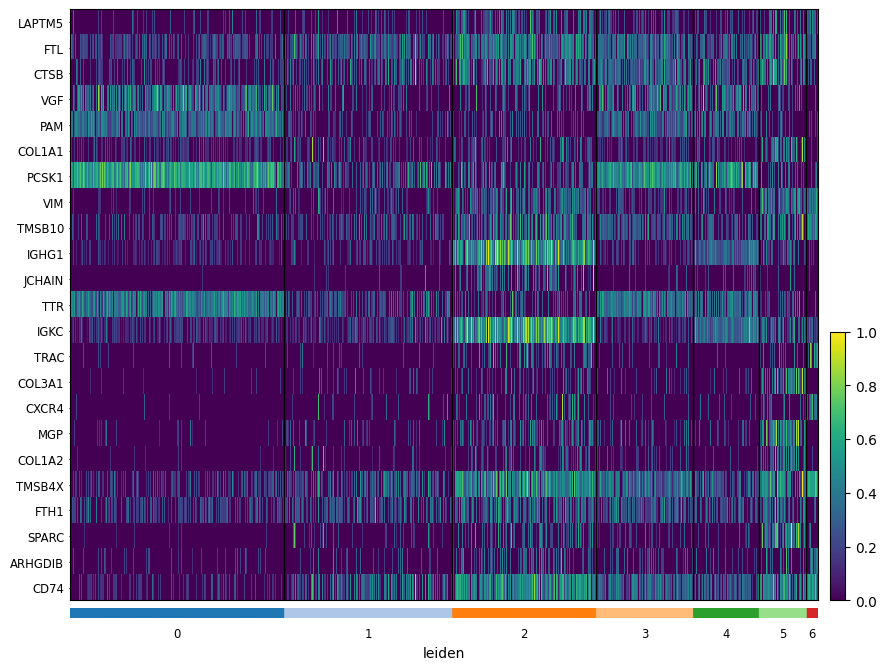

==== 所有 top genes（去重后） ====
['LAPTM5', 'FTL', 'CTSB', 'VGF', 'PAM', 'COL1A1', 'PCSK1', 'VIM', 'TMSB10', 'IGHG1', 'JCHAIN', 'TTR', 'IGKC', 'TRAC', 'COL3A1', 'CXCR4', 'MGP', 'COL1A2', 'TMSB4X', 'FTH1', 'SPARC', 'ARHGDIB', 'CD74']
总共 23 个基因

Banksy Cluster 0 Top 10 genes:
['PCSK1', 'TTR', 'PAM', 'VGF', 'IGKC', 'FTL', 'FTH1', 'TMSB4X', 'IGHG1', 'TMSB10']

Banksy Cluster 1 Top 10 genes:
['FTL', 'CD74', 'IGKC', 'TMSB4X', 'FTH1', 'PCSK1', 'TTR', 'CTSB', 'TMSB10', 'IGHG1']

Banksy Cluster 2 Top 10 genes:
['IGKC', 'IGHG1', 'TMSB4X', 'CD74', 'FTL', 'TMSB10', 'CTSB', 'VIM', 'FTH1', 'JCHAIN']

Banksy Cluster 3 Top 10 genes:
['PCSK1', 'TMSB4X', 'FTL', 'TTR', 'CD74', 'PAM', 'CTSB', 'VGF', 'FTH1', 'TMSB10']

Banksy Cluster 4 Top 10 genes:
['IGKC', 'IGHG1', 'PCSK1', 'TTR', 'PAM', 'VGF', 'TMSB4X', 'CD74', 'FTL', 'FTH1']

Banksy Cluster 5 Top 10 genes:
['IGKC', 'TMSB4X', 'CD74', 'MGP', 'VIM', 'COL1A1', 'COL3A1', 'SPARC', 'COL1A2', 'FTL']

Banksy Cluster 6 Top 10 genes:
['TMSB4X', 'CD74', 'VIM', 'TMSB10'

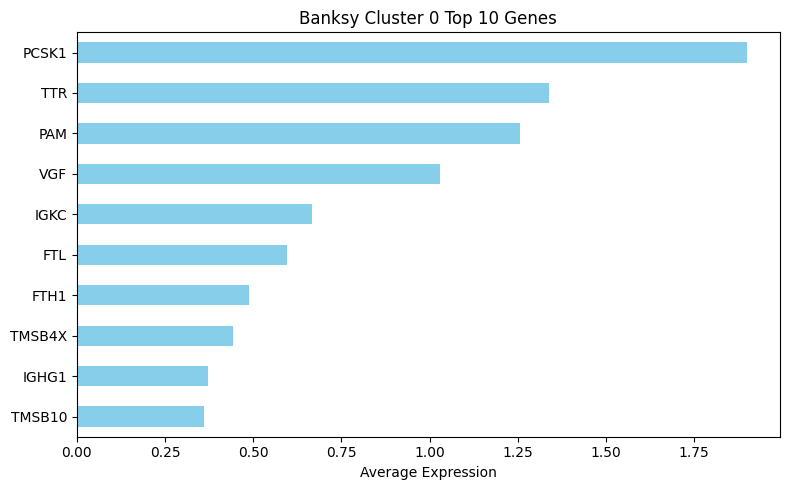

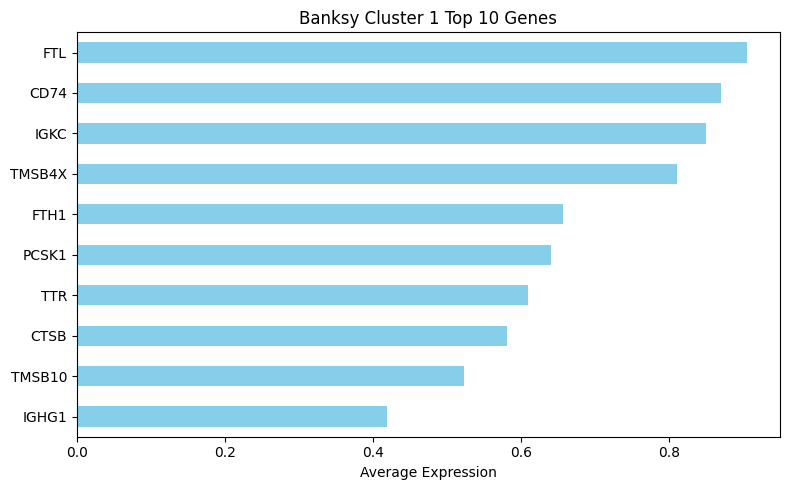

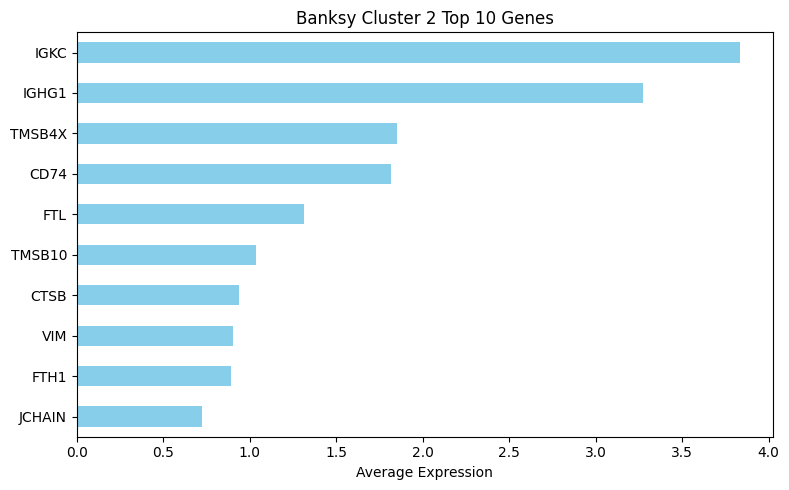

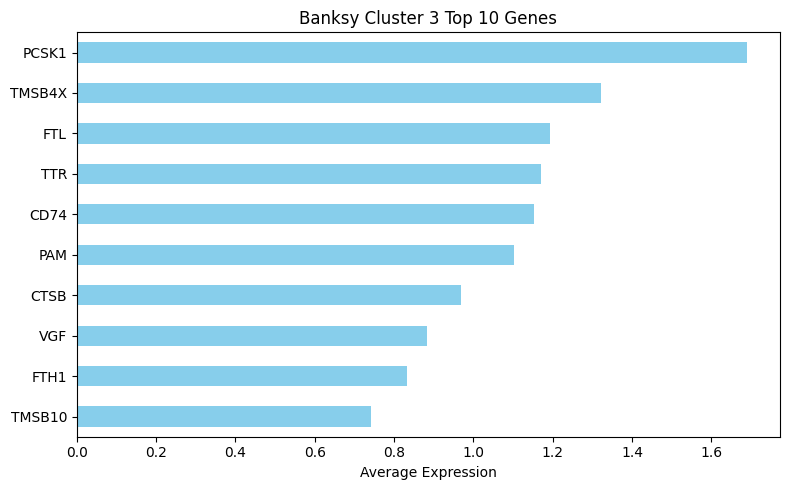

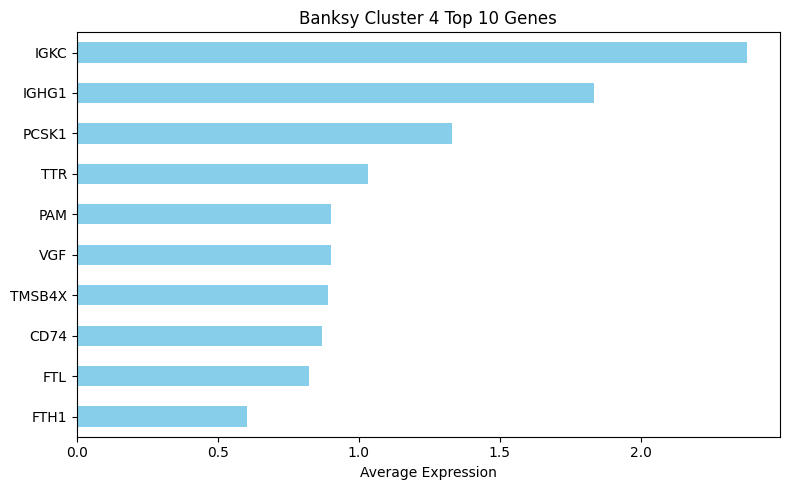

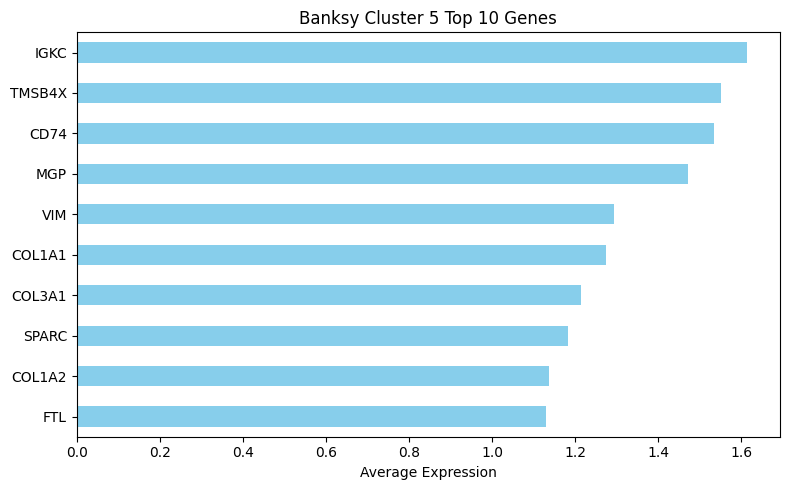

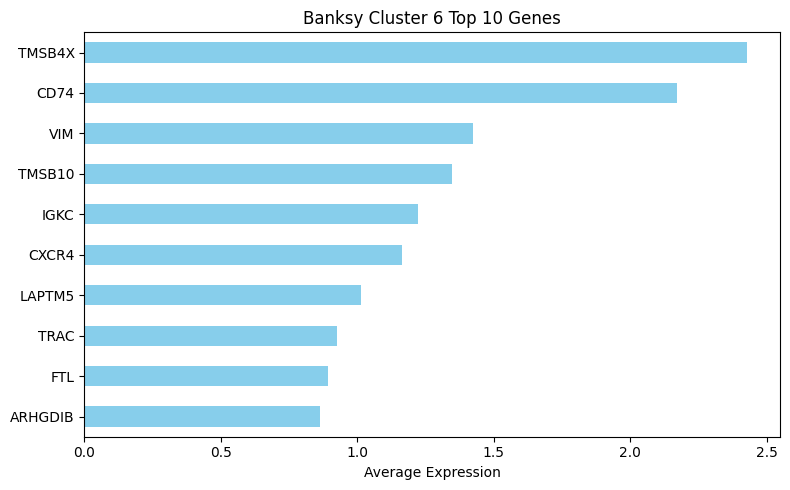

In [ ]:
import matplotlib.pyplot as plt
import os

adata.var_names_make_unique()

groupby = "leiden"
expr = adata.to_df()
expr[groupby] = adata.obs[groupby].values

mean_exp = expr.groupby(groupby).mean().T

top_genes = {}
for cluster in mean_exp.columns:
    top_genes[cluster] = mean_exp[cluster].sort_values(ascending=False).head(10).index.tolist()

top_gene_list = list(set(sum(top_genes.values(), [])))
sc.pl.heatmap(
    adata,
    var_names=top_gene_list,
    groupby=groupby,
    cmap="viridis",
    standard_scale="var",
    swap_axes=True,
    figsize=(10,8),
    show=True
)

for cluster, genes in top_genes.items():
    cluster_mean = mean_exp[cluster].loc[genes]

    plt.figure(figsize=(8,5))
    cluster_mean.sort_values().plot(kind='barh', color='skyblue')
    plt.xlabel("Average Expression")
    plt.title(f"Banksy Cluster {cluster} Top 10 Genes")
    plt.tight_layout()

print("==== 所有 top genes（去重后） ====")
print(top_gene_list)
print(f"总共 {len(top_gene_list)} 个基因\n")

for cluster, genes in top_genes.items():
    print(f"Banksy Cluster {cluster} Top 10 genes:")
    print(genes)
    print()

In [ ]:
expr_matrix = adata.X.toarray() if hasattr(adata.X, "toarray") else adata.X
expr_df = pd.DataFrame(expr_matrix, index=adata.obs_names, columns=adata.var_names)

expr_df.T.to_csv("/content/expression_matrix_for_SingleR.csv")

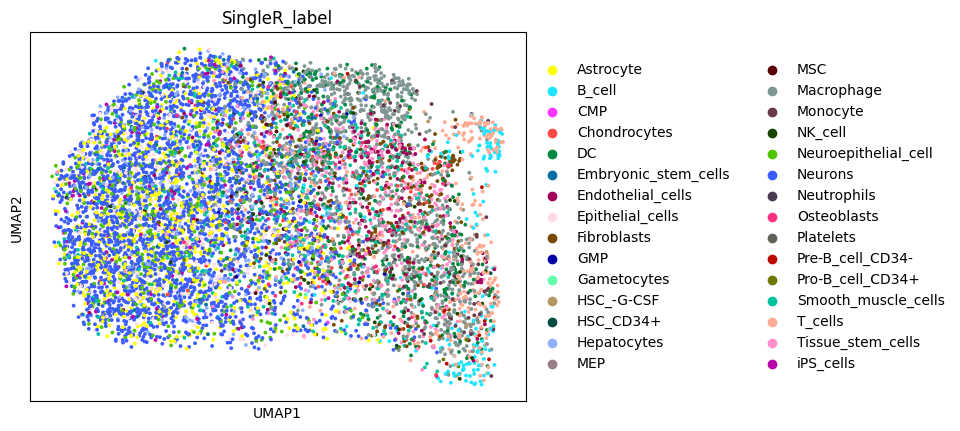

In [ ]:
import pandas as pd

singleR_df = pd.read_csv("/content/SingleR_HPCA_BANKSY_results.csv", index_col=0)

adata.obs['SingleR_label'] = singleR_df['HPCA_label'].reindex(adata.obs_names)

sc.pp.neighbors(adata, use_rep='X_pca')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['SingleR_label'], size=30)

/tmp/ipython-input-627840653.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(cluster_key)["SingleR_celltype"]


✅ Cluster-level BANKSY+SingleR annotations saved to: /content/SingleR_BANKSY_cluster_annotations.csv
  leiden SingleR_cluster_annotation
0      0                    Neurons
1      1                    Neurons
2      2           Pre-B_cell_CD34-
3      3                         DC
4      4                 Macrophage


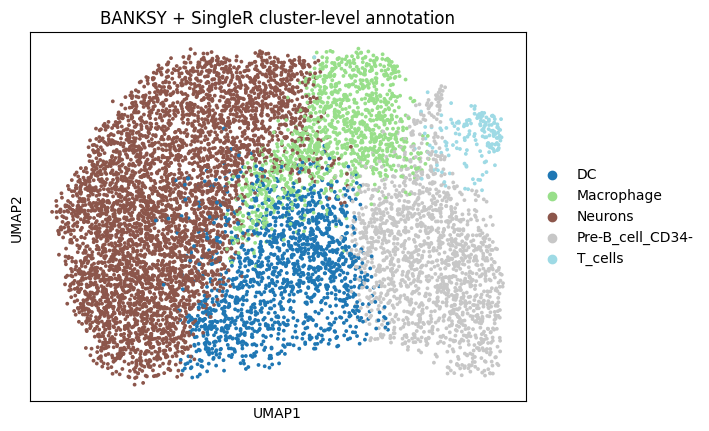

In [ ]:
import pandas as pd
import scanpy as sc

singleR_file = "/content/SingleR_Banksy_results.csv"
singleR_labels = pd.read_csv(singleR_file)

cluster_dict = pd.Series(
    singleR_labels.iloc[:, 1].values,
    index=singleR_labels.iloc[:, 0].astype(str)
).to_dict()

adata.obs["SingleR_celltype"] = adata.obs_names.astype(str).map(cluster_dict)

cluster_key = "leiden"

cluster_annotations = (
    adata.obs.groupby(cluster_key)["SingleR_celltype"]
    .agg(lambda x: x.mode()[0] if not x.mode().empty else "Unknown")
)

adata.obs["SingleR_cluster_annotated"] = adata.obs[cluster_key].map(cluster_annotations)

cluster_annotations_df = cluster_annotations.reset_index()
cluster_annotations_df.columns = [cluster_key, "SingleR_cluster_annotation"]

out_file = "/content/SingleR_BANKSY_cluster_annotations.csv"
cluster_annotations_df.to_csv(out_file, index=False)

print(" Cluster-level BANKSY+SingleR annotations saved to:", out_file)
print(cluster_annotations_df.head())

if "X_umap" not in adata.obsm_keys():
    print("No UMAP found, recomputing ...")
    if "X_pca" not in adata.obsm_keys():
        sc.pp.pca(adata, n_comps=20, use_highly_variable=False)
    sc.pp.neighbors(adata, use_rep="X_pca")
    sc.tl.umap(adata)

sc.pl.umap(
    adata,
    color="SingleR_cluster_annotated",
    title="BANKSY + SingleR cluster-level annotation",
    palette="tab20",
    size=30
)
